In [16]:
import numpy as np
from numpy import inf as inf
from scipy.stats import binom
from heapq import heappush, heappop
import matplotlib.pyplot as plt
import timeit

In [17]:
def connectGraph(graph):
    """
    Esta función se asegura que la matriz de adyacencia que entra por parámetro defina
    un grafo conexo, lo hace agragando una conexión aleatoria que llega a un nodo 
    identificado como no conexo. 
    @param graph: Matriz de adyacencia de un grafo conexo.
    """
    n = len(graph)
    for i in range(n):
        #Suma entradas de la i esima columna sin contar la diagonal
        incoming = np.sum(np.delete(graph[:, i], i)) 
        if incoming == 0:
            pos = np.random.randint(0, n-1)
            # Nos aseguramos de no poner la nueva conexión en la diagonal
            pos = pos if pos < i else pos + 1
            graph[pos, i] = 1



def generateRandomConnectedGraph(n, connectness: float = 0.2):
    """
    Esta función genera la matriz de adyacencia de un grafo dirigido, con pesos entre 1 y 50. 
    simplemente conexo y con N nodos.
    @param n: Número de nodos del grafo
    @param connectness: indica, en promedio, el porcentaje de vertices que llegarán y saldrán de un nodo. 
    El rango es entre 0 y 1.
    return: Matriz de adyacencia del grafo y la matriz de pesos
    """
    # Una grafo simplemente conexo tendrá, por cada columna, al menos un valor distinto de
    # cero en las entradas que no son la perteneciente a la diagonal. i.e, para que sea
    # conexo, por cada nodo, siempre debe haber un vertice que llega a dicho nodo

    # Inicialización de los vertices del grafo. 
    adyacencia = np.double(binom.rvs(1, connectness, size=n*n).reshape((n, n)))
    # Nos aseguramos que sea conexo
    connectGraph(adyacencia)
    # Generamos los pesos
    pesos = np.multiply(adyacencia, np.random.randint(1, 51, (n, n)))
    # Si no hay conexión a un nodo el peso es infinito
    pesos[pesos == 0] = inf 

    return adyacencia, pesos


In [18]:
grafo, pesos = generateRandomConnectedGraph(10, connectness = 0.3)
print(pesos)

[[26. 36. inf inf 41. inf 36. inf 11. inf]
 [31. inf 37. inf inf 48. 42. inf inf inf]
 [inf inf inf inf inf inf inf inf inf inf]
 [16. inf inf inf inf inf 32. inf 22. inf]
 [inf inf inf inf 48. inf inf inf inf inf]
 [inf inf inf 29. inf inf inf 29. inf inf]
 [inf 39.  7. inf inf inf inf inf 25. 16.]
 [17. inf inf inf 27. 15. inf 23. inf 47.]
 [inf 32. inf 33. inf inf inf 10. 10. 21.]
 [ 1. 32. inf 47. inf  8. inf inf inf inf]]


In [19]:
print(pesos)

[[26. 36. inf inf 41. inf 36. inf 11. inf]
 [31. inf 37. inf inf 48. 42. inf inf inf]
 [inf inf inf inf inf inf inf inf inf inf]
 [16. inf inf inf inf inf 32. inf 22. inf]
 [inf inf inf inf 48. inf inf inf inf inf]
 [inf inf inf 29. inf inf inf 29. inf inf]
 [inf 39.  7. inf inf inf inf inf 25. 16.]
 [17. inf inf inf 27. 15. inf 23. inf 47.]
 [inf 32. inf 33. inf inf inf 10. 10. 21.]
 [ 1. 32. inf 47. inf  8. inf inf inf inf]]


In [20]:
def execTime(func):
    """
    Definici;on de un decorador que se usa para retornar el tiempo 
    de ejecución de una función. 
    @param func. La función a la que se le medirá el tiempo de ejecución
    @return time, result. 
    time: Tiempo en segundos de la ejecución de la función.
    result: Resultado de la función. 
    """
    def wrapper(*args, **kwargs):
        init_time = timeit.default_timer()
        result = func(*args, **kwargs)
        stop_time = timeit.default_timer()
        total = stop_time - init_time
        return total, result
    return wrapper

In [66]:
@execTime
def dijkstra(pesos, init):
    """ 
    Implementación eficiente de Dijkstra usando priority queue con la libraría
    de Python heapq (no hay que descargarla, hace parte del core de Python)
    @param pesos: Matriz de pesos de grafo dirigido. Solo positivos.
    @param init: Nodo de inicio del algoritmo. Debe estar entre 0 y len(pesos) - 1.
    """

    # Número de nodos
    n = len(pesos)

    # Inicialización de arreglos auziliares y el vector respuesta (path)
    dist = np.ones(n) * inf
    visited = np.array([False for i in range(n)])
    path = np.ones(n) * -1

    dist[init] = 0
    visited[init] = True

    heap = []
    # Priority queue. Se ordena el heap basado en la primera entrada de la tupla 
    # (distancia, posicion) que se le pasa. Sacar el mínimo es O(1)
    heappush(heap, (dist[init], init))

    while len(heap) > 0:

        (minimo, nodoMin) = heappop(heap)
        nodoMin = int(nodoMin)
        visited[nodoMin] = True

        # Se recorren los nodos con pesos menores a infinito (los vecinos)
        for v in (v for v, peso in enumerate(pesos[nodoMin, :]) if peso < inf):
            if not visited[v]:
                # print('min: ',  nodoMin, 'v:', v, '-', dist[nodoMin], '-', pesos[nodoMin, v])

                # Si el nodo no ha sido visitado y la distancia desde el actual es menor
                # Entonces se actualiza su distancia
                if dist[v] > dist[nodoMin] + pesos[nodoMin, v]:

                    dist[v] = dist[nodoMin] + pesos[nodoMin, v]
                    path[v] = nodoMin
                    heappush(heap, (dist[v], v))

    return path


In [22]:
time, path = dijkstra(pesos, 3)
print('La función demoró:', time*1000, 'ms corriendo')
print(path)

La función demoró: 0.16370000048482325 ms corriendo
[ 3.  0.  6. -1.  0.  7.  3.  8.  3.  8.]


In [73]:


def graphExecutionTimes(samples=50, maxNodes=200, connectness = 0.3):
    """
    Función principal que se encarga de graficar el tiempo de ejecución de Dijkstra y 
    optimización dado el crecimiento de los nodos.

    @param samples: Número de muestrasa de grafos que se generarán por cada incremento en el 
    número de nodos. Los resultados graficados será el promedio de estas muestras
    @param masNodes: Número máximo de nodos a evaluar. Se empieza con grafos de 5 nodos y aumenta
    progresivamente el número de nodos hasta este valor.
    @param connectness: Qué tan conectados van a estar los grafos creados. Toma un valor entre 0 y 1. 
    Que este en 0 no significa que el grafo no sea conexo, siempre nos aseguramos que cualquier grafo
    generado sea conexo. A grandes rasgos este número indica, para un nodo, el porcentaje del total de
    nodos conectados a él. 
    """

    dijkstraTimes = []
    optiTimes = []

    for n in range(5, maxNodes):

        sampleTimeDij = []
        # print(n)

        for sample in range(samples):
            # Genera un grafo conexo de n nodos
            grafo, pesos = generateRandomConnectedGraph(n, connectness = connectness)
            startNode = np.random.randint(0, n)

            # Primero con dijkstra
            nthTime, path = dijkstra(pesos, startNode)
            sampleTimeDij.append(nthTime)

            # TODO acá viene resolverlo con optimización
        
        avgTime = sum(sampleTimeDij)/ len(sampleTimeDij)
        dijkstraTimes.append(avgTime)
    
    
    dijkstraTimes = np.array(dijkstraTimes)

    # Plot results
    E = lambda V: V*(V-1)*connectness #Número aproximado de vertices según el algoritmo de generación
    dijkComplFunc = lambda V: V + E(V)*np.log(V)

    # Factor de Reajuste del cálculo de complejidad (Empírico)
    C = min(np.array(dijkstraTimes[:5]))/80
    dijkCompl = np.array([dijkComplFunc(V) for V in range(5, maxNodes)]) * C

    plt.plot(list(range(5, maxNodes)), dijkstraTimes*1000, color='b', label='Tiempos usando Dijkstra')
    plt.plot(list(range(5, maxNodes)), 
            dijkCompl*1000, color='y', 
            label='Complejidad Teórica de Dijsktra O(V + E LogV)')
    plt.legend()
    plt.title('Comparación tiempos Dijsktra vs Optimización')
    plt.xlabel('Número de Nodos')
    plt.ylabel('Tiempo de ejecución (ms)')
    plt.grid()
    plt.show()





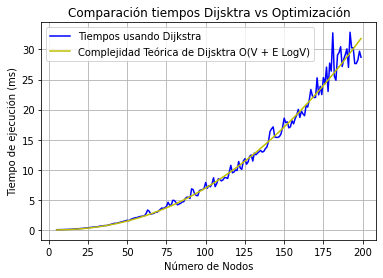

In [74]:
graphExecutionTimes(samples=20, maxNodes=200, connectness = 0.3)